# Temperature and Electricity Demand in Ohio

This notebook looks at the relationship between temperature in Ohio and electricity demand from PJM which measures electricity demand for several states, including Ohio.

In [1]:
import pandas as pd
import json
import requests
from sklearn.preprocessing import StandardScaler
from utils.helper import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


## Temperature

In [2]:
# get temperature data
# round the period_timestamp up to the hour

df_temp = pd.read_csv('weather_data/full_data.csv')
df_temp.head()
df_temp.properties_timestamp = df_temp.properties_timestamp.apply(
    lambda x: round_up_hour(x))

df_temp = df_temp.drop('index', axis=1)
df_temp.index = df_temp.properties_timestamp
df_temp = df_temp.drop('properties_timestamp', axis=1)
# df_temp.reset_index(inplace=True)
df_temp.head()


,properties_temperature_value,properties_relativeHumidity_value
properties_timestamp,,
2023-08-01 10:00:00,17.8,80.502010
2023-08-01 11:00:00,17.8,80.502010
2023-08-01 12:00:00,18.9,75.137366
2023-08-01 13:00:00,20.0,70.170683
2023-08-01 14:00:00,22.2,61.304763


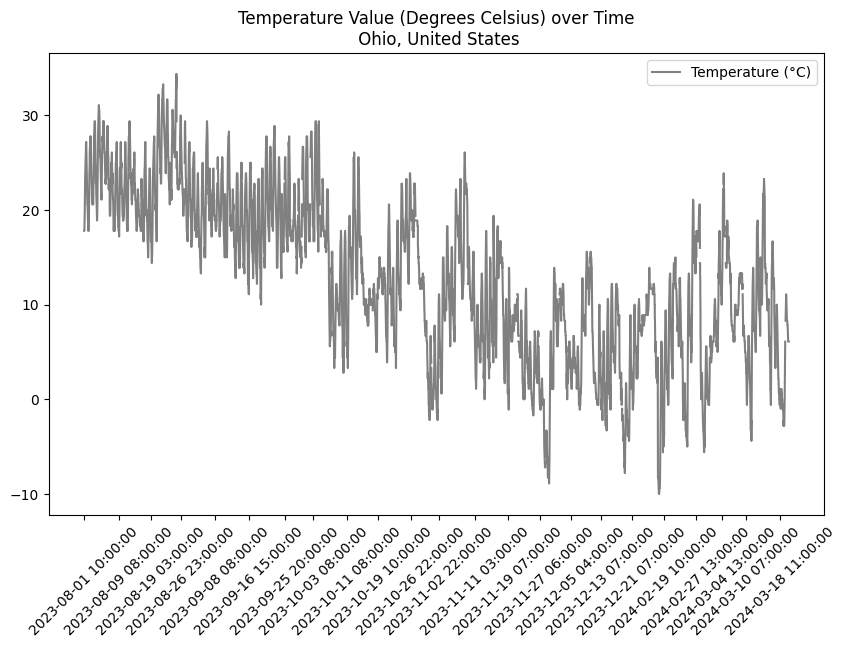

In [3]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the line chart
plt.plot(df_temp.index, df_temp['properties_temperature_value'],
         color='grey', label='Temperature (°C)')

# Add x-ticks every 10 rows
# Every 10th tick and tilted at a 45 degree angle
plt.xticks(df_temp.index[::200], rotation=45)

# Add title and legend
plt.title('Temperature Value (Degrees Celsius) over Time\n Ohio, United States')
plt.legend()

# Show plot
plt.show()


## Electricity

In [84]:
df_list = []

for file in os.listdir('electric_consumption_data'):
    with open(f'electric_consumption_data/{file}') as f:
        data = json.load(f)
    df_list.append(preprocess_electric_hourly_demand_json(data))
df_elec = pd.concat(df_list).sort_values(by='period')
df_elec = df_elec.drop_duplicates()
df_elec.index = df_elec.period
df_elec = df_elec.drop('period', axis=1)
df_elec.head()


,respondent,value-units,value_day_ahead demand forecast,value_demand,value_net generation,value_total interchange
period,,,,,,
2023-08-01 00:00:00,PJM,megawatthours,111378,115248,124354,9109
2023-08-01 01:00:00,PJM,megawatthours,106699,110343,120163,9823
2023-08-01 02:00:00,PJM,megawatthours,99610,105699,115349,9653
2023-08-01 03:00:00,PJM,megawatthours,91964,99422,108610,9191
2023-08-01 04:00:00,PJM,megawatthours,85209,93557,101883,8328


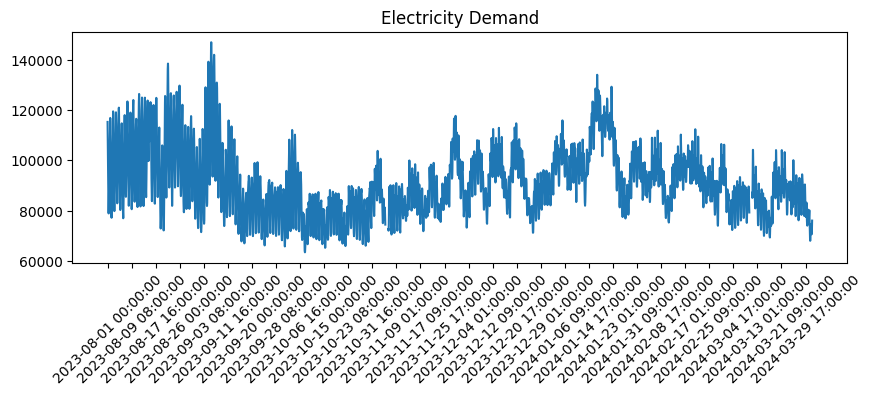

In [87]:
plt.figure(figsize=(10,3))
x = pd.to_numeric(df_elec.value_demand, errors='coerce')
plt.plot(x)
plt.xticks(df_elec.index[::200], rotation=45)
plt.xticks(rotation=45)
plt.title('Electricity Demand')
plt.show()

In [8]:
#df_elec.dtypes
rows_with_null = df_elec[df_elec.isnull().any(axis=1)]
rows_with_null.shape[0]
num_columns = ['value_day_ahead demand forecast','value_demand', 'value_net generation', 'value_total interchange']


In [12]:

column_transformer = ColumnTransformer(
    [('TextToNumericTransformer',
      TextToNumericTransformer(), num_columns)
      ]
)

pipeline = Pipeline([
    ('column_transformer',column_transformer),
    ('forward_fill',ForwardFillTransformer()),
    ('standard_scaler',StandardScaler())
])

h = pipeline.fit_transform(df_elec)
df_elec_tran = pd.DataFrame(h, columns = num_columns)

In [13]:
rows_with_null = df_elec_tran[df_elec_tran.isnull().any(axis=1)]
rows_with_null.shape[0]

0

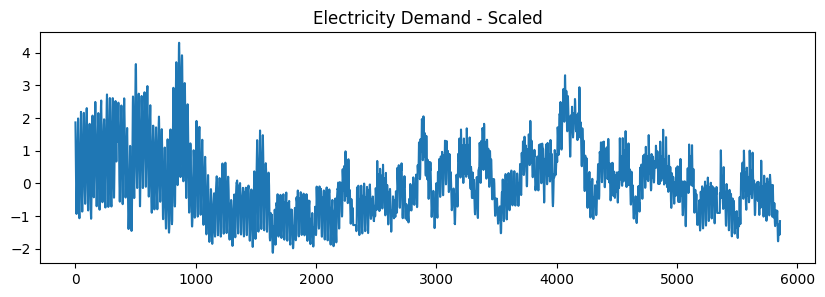

In [75]:
plt.figure(figsize=(10,3))
plt.plot(df_elec_tran.value_demand)
plt.title('Electricity Demand - Scaled')
plt.show()

# Merge Data

In [27]:
column_transformer = ColumnTransformer(
    [('TextToNumericTransformer',
      TextToNumericTransformer(), num_columns)
      ]
)

pipeline = Pipeline([
    ('column_transformer',column_transformer),
    ('forward_fill',ForwardFillTransformer())
])

h = pipeline.fit_transform(df_elec)
df_elec_clean = pd.DataFrame(h, columns = num_columns, index = df_elec.index)

df = pd.merge(left=df_elec_clean, right=df_temp, left_index=True, right_index=True)

# Visualize Electricity and Temperature

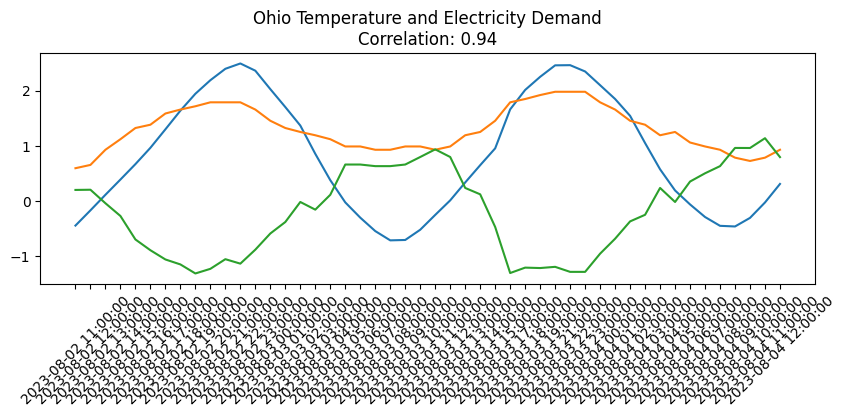

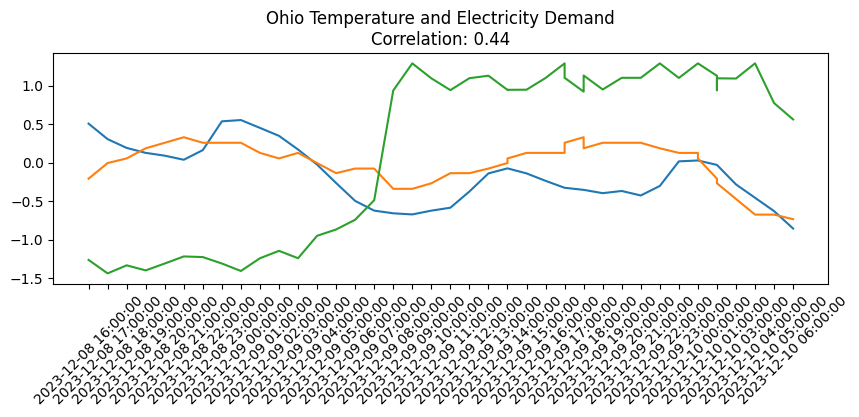

In [72]:
# smaller dataframe
columns = ['value_demand','properties_temperature_value', 'properties_relativeHumidity_value']
df_s = df[columns]

scaler = StandardScaler()
df_scaled = pd.DataFrame(data = scaler.fit_transform(df_s), columns = columns, index=df_s.index)

start_val = 24
plt.figure(figsize=(10,3))
plt.plot(df_scaled.iloc[start_val:start_val+48])

corr_ = df_scaled.iloc[start_val:start_val+48].corr().loc['value_demand']['properties_temperature_value']
plt.title(f"Ohio Temperature and Electricity Demand\nCorrelation: {np.round(corr_,2)}")
plt.xticks(rotation=45)
plt.show()

start_val = 3100
plt.figure(figsize=(10,3))
plt.plot(df_scaled.iloc[start_val:start_val+48])
#.plot()
corr_ = df_scaled.iloc[start_val:start_val+48].corr().loc['value_demand']['properties_temperature_value']
plt.title(f"Ohio Temperature and Electricity Demand\nCorrelation: {np.round(corr_,2)}")
plt.xticks(rotation=45)
plt.show()


i = 0
corr_list = []
indices = []
while i+48 <= df_scaled.shape[0]:
    i += 48
    corr_df = pd.DataFrame(data = df_scaled.iloc[i:i+48].corr().loc['value_demand']).T.reset_index(drop=True)
    corr_list.append(corr_df)
    indices.append(df_scaled.index[i])

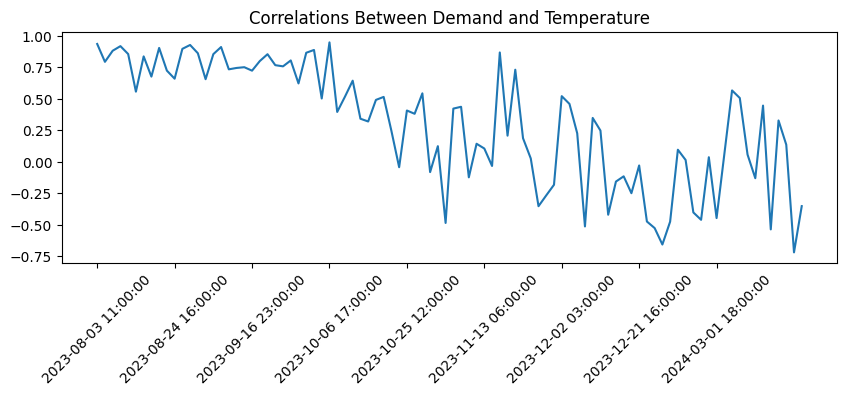

In [71]:
df_corrs = pd.concat(corr_list)
df_corrs.index = indices
plt.figure(figsize=(10,3))
plt.plot(df_corrs.properties_temperature_value)
plt.xticks(ticks=range(0,90,10),rotation=45)
plt.title("Correlations Between Demand and Temperature")
plt.show()